# ML Models for Failure Detection and Predictive Maintenance

#### Outline
1. Data Preparation and Preprocessing
2. Random Forest Model
3. Logistic Regression Model
4. MLP Model
5. Results and Evaluation

In [83]:
# pip install imbalanced-learn
# pip install plotly

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,roc_auc_score, matthews_corrcoef
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

### 1. Data Preparation and Preprocessing

#### About the data
The set includes different milling machines' features and their failure modes. 

*Data sources:*
1. **Available Predictive Maintenance Dataset (AI4I 2020):** please refer to https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020 <br> *Data set copyright notice: S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.*
2. **Collected data**

#### Data collection
Todo Ali

#### Load the dataset

In [48]:
# read csv file of data set
dataset = pd.read_csv("Machine-Failure-Dataset.csv")

# show first rows of data set
dataset.head(3)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


**The failure modes explained:**
- TWT (tool wear failure): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins.
- HDF (heat dissipation failure): if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm, the process fails.
- PWF (power failure): if this power required for the process is below 3500 W or above 9000 W, the process fails.
- OSF (overstrain failure): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant, the process fails. 
- RNF (random failures): each process has a chance of 0,1 % to fail regardless of its process parameters.

If at least one of the above failure modes is true, the process fails and the *machine failure* label is set to 1.

#### Explore the data

In [49]:
# drop UDI and Product ID columns
dataset.drop(['Product ID', 'UDI'], axis=1, inplace = True)

dataset.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


#### Distribution of failure modes

Text(0.5, 1.0, 'Failure mode per machine type')

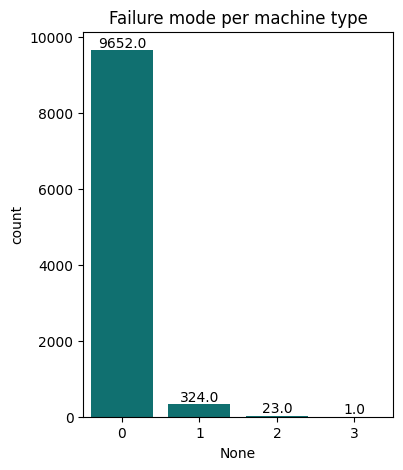

In [50]:
failure_modes = dataset.loc[:, ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

# Calculate the sum of the values in each row
rows_sum = failure_modes.sum(axis=1)

fig, ax = plt.subplots(figsize=(4, 5))
sns.countplot(x=rows_sum, ax=ax, color='#008080')

for patch in ax.patches:
    ax.annotate(str(patch.get_height()), (patch.get_x() + patch.get_width()/2, patch.get_height()), ha='center', va='bottom')
    
ax.set_title('Failure mode per machine type')

<Axes: xlabel='Machine failure', ylabel='Count'>

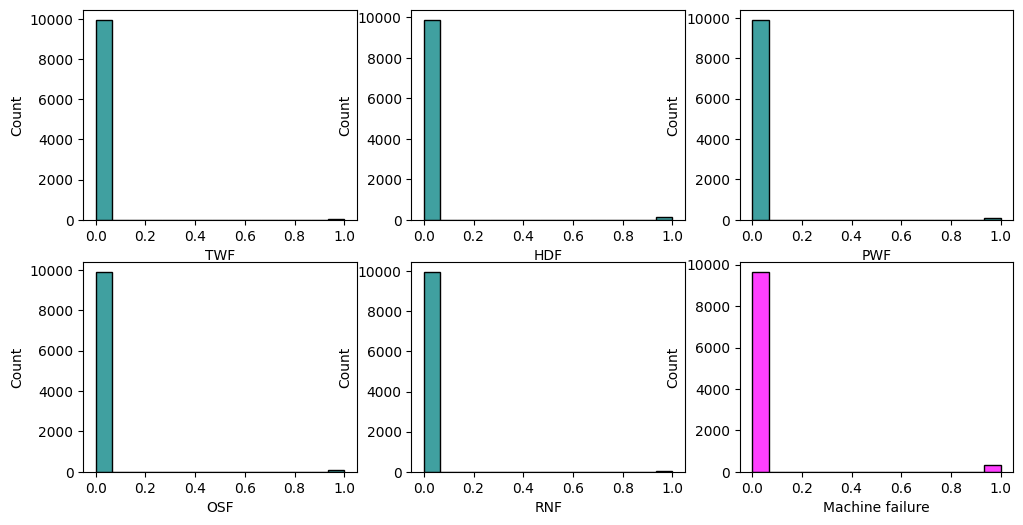

In [51]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for i, col in enumerate(failure_modes):
    sns.histplot(dataset[col], ax=ax[i//3][i%3], color='#008080')

# Plot Machine failure in last subplot
sns.histplot(dataset['Machine failure'], ax=ax[1][2], color='#FF00FF')

So since the count of every single failure type is very small compared to the entire data set, we only consider the combined feature ***Machine failure***. The individual failure types are dropped.

In [52]:
# drop individual failure types
dataset.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

In [53]:
dataset.head(3)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0


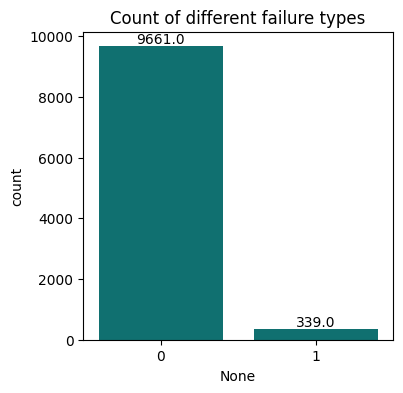

In [54]:
failure_types = dataset.loc[:, ['Machine failure']]

rows_sum = failure_types.sum(axis=1)

fig, ax = plt.subplots(figsize=(4, 4))
sns.countplot(x=rows_sum, ax=ax, color='#008080')
for patch in ax.patches:
    ax.annotate(str(patch.get_height()), (patch.get_x() + patch.get_width()/2, patch.get_height()), ha='center', va='bottom')
    ax.set_title('Count of different failure types')

#### Suggestion: Data Augmentation through a Synthetic Minority Over-sampling Technique (SMOTE)??
SMOTE is a method to over-sample minority classes. <br>
For more infos please refer to https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn

In [55]:
smote = SMOTE(random_state=42)
data_resampled = smote.fit_resample(dataset[['Process temperature [K]','Torque [Nm]', 'Tool wear [min]']], 
                                    dataset['Machine failure'])

In [56]:
# data_resampled[0].describe()

In [57]:
# data_resampled[1]

#### Old vs New distribution: ok sry this makes no sense: ELIMINATE

<Axes: xlabel='Machine failure', ylabel='Count'>

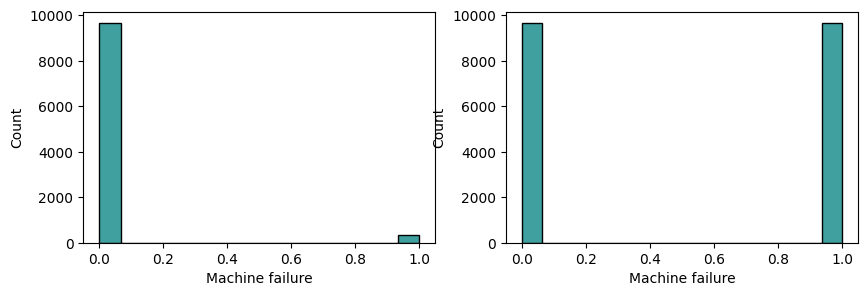

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.histplot(dataset['Machine failure'], ax=ax[0], color='#008080')
sns.histplot(data_resampled[1], ax=ax[1], color='#008080')

#### Handling Outliers
We calculate and handle the outliers for each attribute using IQR, which is the interquartile range.

In [59]:
excluded_columns = ['Type', 'Machine failure']

for col in dataset.columns:
    if col not in excluded_columns:
        # convert to float
        dataset[col] = dataset[col].astype(float)
        # calculate the IQR 
        Q1 = dataset[col].quantile(0.25)
        Q3 = dataset[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = dataset[(dataset[col] <= (Q1 - 1.5 * IQR)) | (dataset[col] >= (Q3 + 1.5 * IQR))]
        if not outliers.empty:
          dataset.drop(outliers.index, inplace=True)

#### Density-Based Anomaly Detection (LOF)
The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors.

More infos: https://scikit-learn.org/1.5/auto_examples/neighbors/plot_lof_outlier_detection.html

In [60]:
# convert the 'type' column to numbers (float) for processing of the whole dataset as float
dataset['Type'].replace('L', 0, inplace=True)  # L = 0
dataset['Type'].replace('M', 1, inplace=True)  # M = 1
dataset['Type'].replace('H', 2, inplace=True)  # H = 2

In [61]:
# create the LOF model
model = LocalOutlierFactor(n_neighbors=5)

# use the model to predict the outlier scores for each row
scores = model.fit_predict(dataset)

# identify the outlier rows (those with a negative score) and remove them
outliers = dataset[scores == -1]

In [62]:
dataset['outlier_score'] = scores  # Add outlier scores as a column to the DataFrame

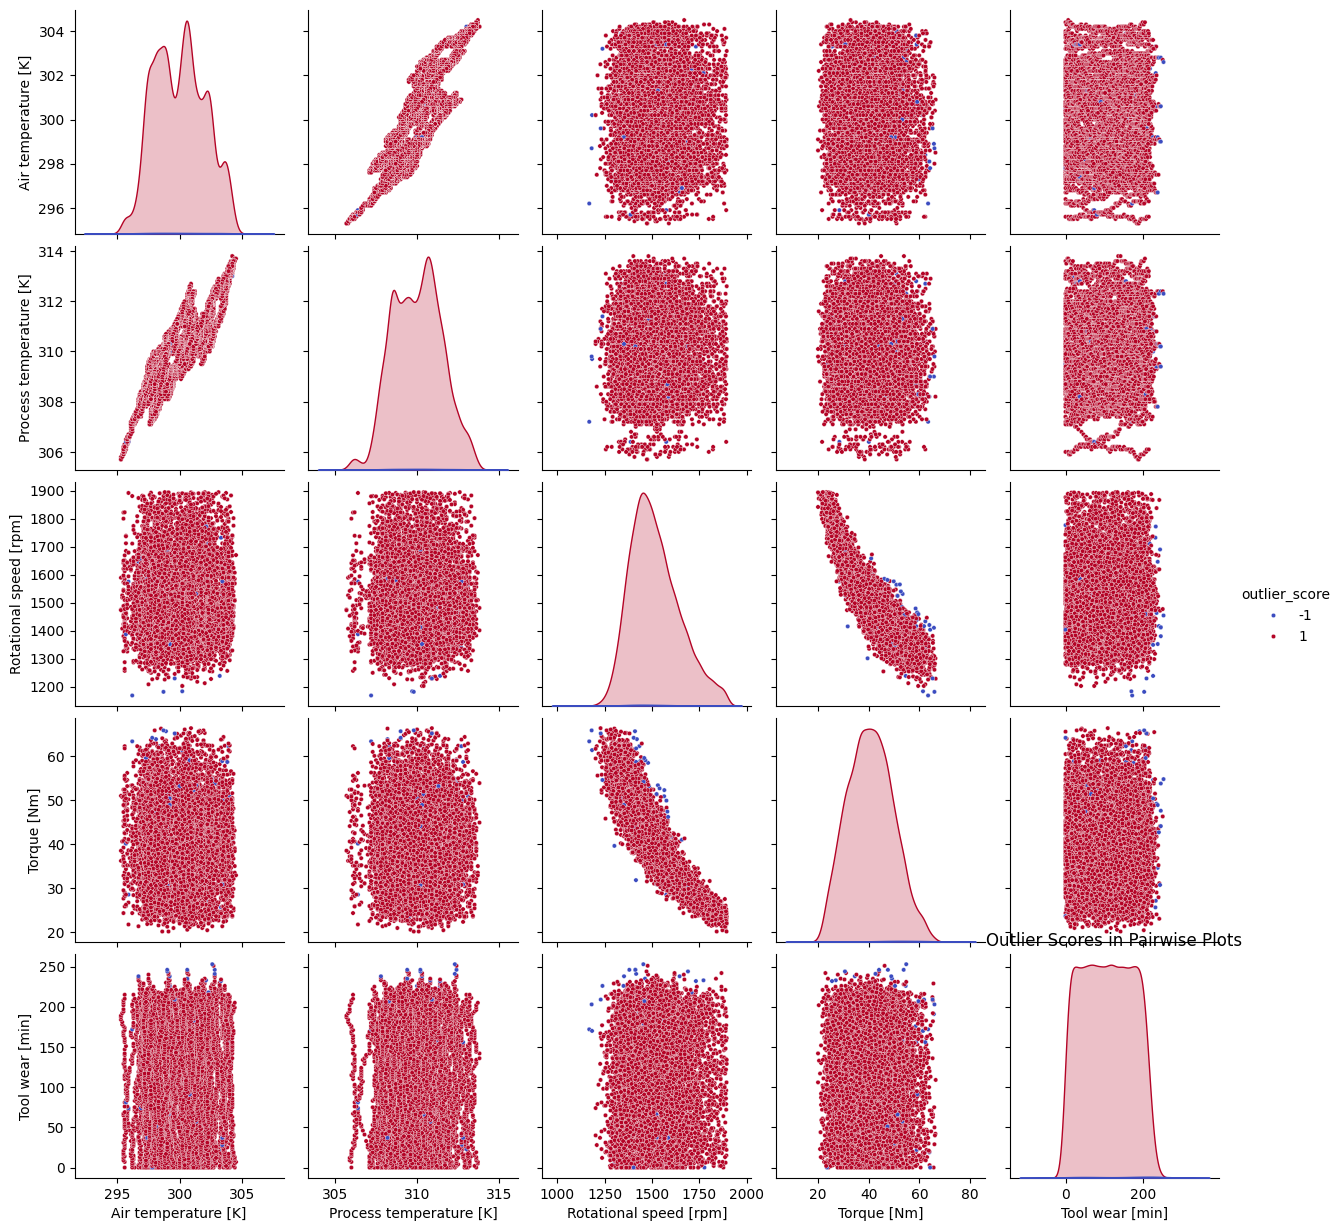

In [63]:
# Create a pairplot and color the points by outlier score
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'outlier_score']

sns.pairplot(dataset[features], hue='outlier_score', palette='coolwarm', plot_kws={'s': 10})
plt.title("Outlier Scores in Pairwise Plots")
plt.show()

In [64]:
dataset.drop(['outlier_score'], axis=1, inplace=True)

if not outliers.empty:
    dataset.drop(outliers.index, inplace=True)

# shape after removing the outliers
dataset.shape 

(9485, 7)

#### Data normalization

In [65]:
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

scaler = MinMaxScaler()
dataset[features] = scaler.fit_transform(dataset[features])

# Check normalized Values
dataset[features].head(3)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,0.304348,0.358025,0.503608,0.490281,0.000000
1,0.315217,0.370370,0.297258,0.565875,0.011952
2,0.304348,0.345679,0.427128,0.632829,0.019920


#### Correlation between features
There is a strong correlation between:
- Process and air temperature: We can drop one of the temperatures, we will drop the air temperature later.
- Torque and rotational speed: the torque to rotational speed difference might be a indication of a failure, so we'll keep both.

<Axes: >

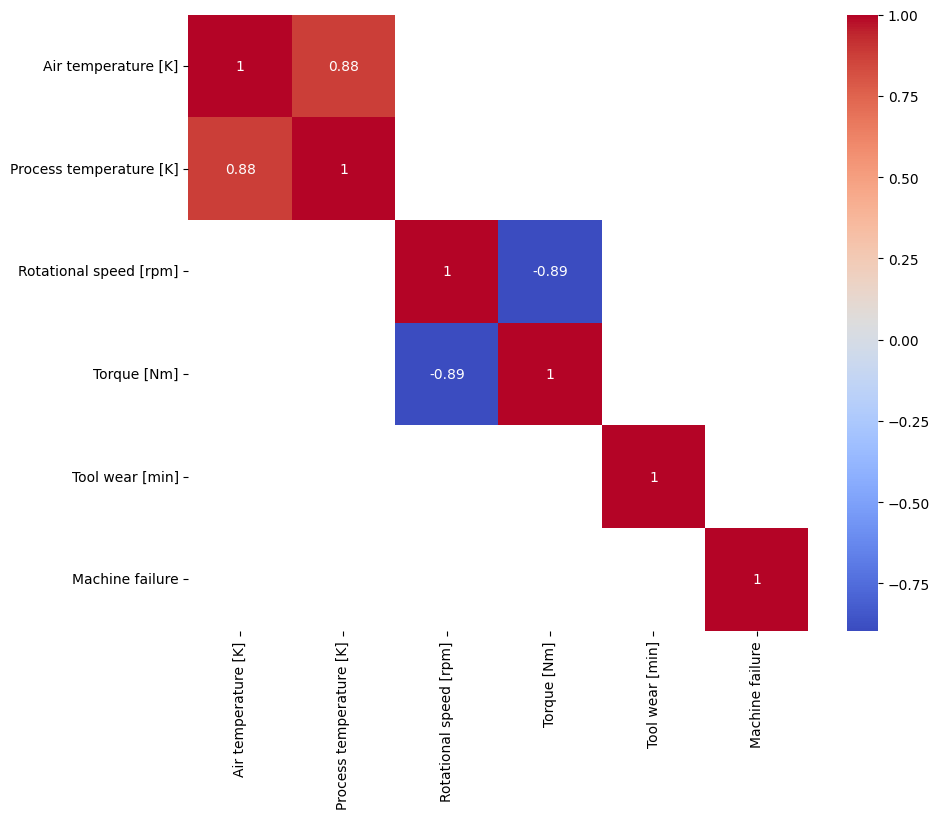

In [66]:
dataset.drop(['Type'],axis=1,inplace=True) # we don't need it, just note it is over dominated by type L

threshold = 0.3
correlation = dataset.corr()
matrix = correlation.where((abs(correlation) >= threshold)).isna()
plt.figure(figsize=(10, 8))
sns.heatmap(dataset.corr(), cmap="coolwarm", annot=True, mask=matrix)

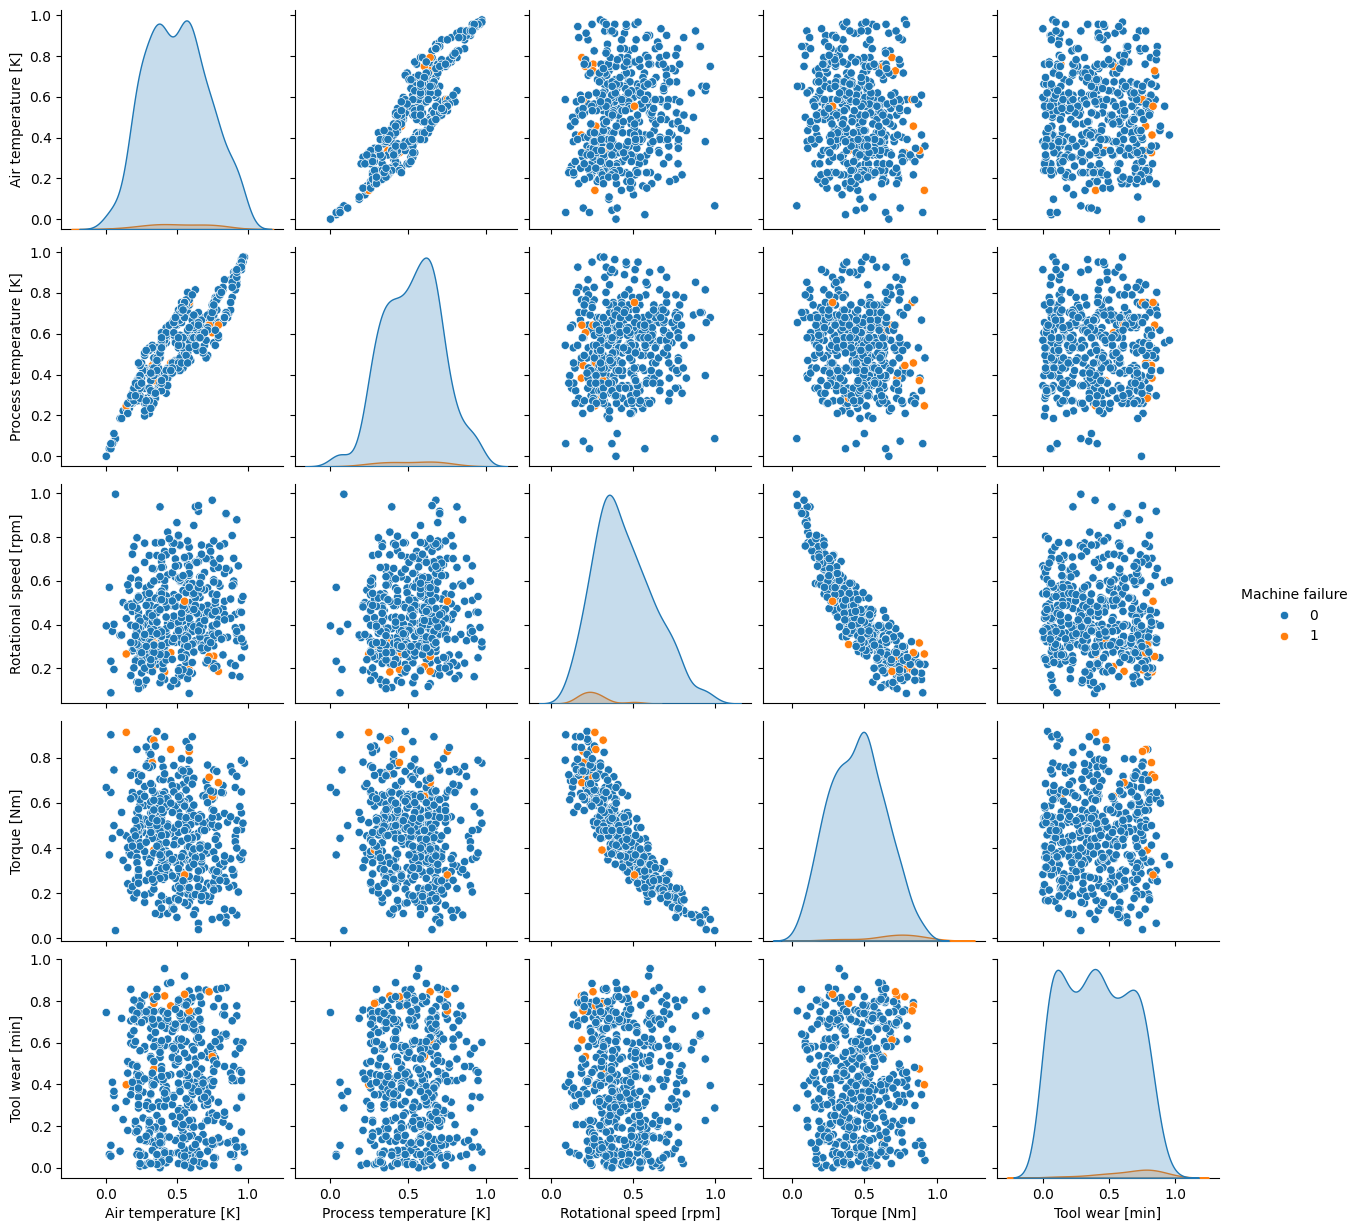

In [67]:
#### Scatter plot
sns.pairplot(dataset.sample(frac=0.05), hue='Machine failure')

#### Feature selection
We want to determine the best features that represent the dataset to use them as training inputs.

Therefore we perform a **statistical univariate test**: tests that involve one dependent variable.

In [68]:
best_features = SelectKBest(score_func=chi2,k='all')

X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]

fit = best_features.fit(X,y)

df_scores=pd.DataFrame(fit.scores_)
df_col=pd.DataFrame(X.columns)

feature_score=pd.concat([df_col,df_scores],axis=1)
feature_score.columns=['feature','score']
feature_score.sort_values(by=['score'],ascending=True,inplace=True)

fig = go.Figure(go.Bar(
            x=feature_score['score'][0:21],
            y=feature_score['feature'][0:21],
            orientation='h'))

fig.update_layout(title="Feature scores",
                  height=500,
                  showlegend=False,
                 )

fig.show()

In [69]:
# features = ['Air temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
features = feature_score.feature.tolist()
target = 'Machine failure'

# Split data
X = dataset[features]
Y = dataset[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2, random_state=42 , stratify=Y )

### 2. Random Forest Model
#### Intro
todo Vinit
#### Model structure: 
maybe do a graph to show the structure of our random forest? todo!

In [70]:
# Initialize
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= "balanced", min_samples_split=5, min_samples_leaf=10, max_depth=10)

#### Model training

In [71]:
rf.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, min_samples_split=5,
                       random_state=42)

#### Model predictions

In [72]:
# Predictions of random forest model
Y_pred_rf = rf.predict(X_test)

# Generate prediction for training data
Y_pred_rf_train = rf.predict(X_train)

### 3. Logistic Regression Model

In [73]:
# Initialize
lr = LogisticRegression(random_state=42, class_weight= "balanced")

#### Model training

In [74]:
# Train
lr.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced', random_state=42)

#### Model predictions

In [75]:
# Predictions of logistic regression model
Y_pred_lr = lr.predict(X_test)

# Generate prediction for training data
Y_pred_lr_train = lr.predict(X_train)

### 4. Multilayer Perceptron
#### Introduction
<img src="MLP.gif" />

__Multi-Layer Perceptron__ is a type of __Artificial Neural Network (ANN)__ composed of three layers:
1. Input Layer: Where data enters the network.
2. Hidden Layers: Where computations are performed through weighted connections.
3. Output Layer: Where predictions or classifications are made.

MLP is a __fully connected__ network because each neuron in one layer is connected to every neuron in the next layer.

#### Model structure

<img src="MLPStructure.png" style="width:550px;height:400px"/>

* __Neurons:__ These are the basic units of the network. Each neuron receives input from the previous neurons, processes the information using weights and biases, and passes the result to the next layer.
* __Weights:__ Each connection between the neurons is associated with a weight, which adjusts the strength of the input signal.
* __Biases:__ A bias term is added to the input to ensure the model can fit the data better.
* __Activation Functions:__ After summing the inputs and applying the weights, the result passes through an activation function to introduce non-linearity into the model. Common activation functions include ReLU, Sigmoid, and Tanh.

#### Model Training

In [76]:
from sklearn.neural_network import MLPClassifier

import time
start = time.time()
model = MLPClassifier(hidden_layer_sizes = (100,100,), 
                      activation='relu', 
                      solver='adam',
                      batch_size=2000,
                      verbose=0).fit(X_train,Y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

* Prepare Training Data: Clean, normalize, and split the dataset into training and validation sets.
* Initialize Network: Set up neural network architecture with random weights and biases.
* Forward Propagation: Input data passes through network layers, generating predicted output.
* Calculate Loss: Compare predicted output with actual labels using a loss function.
* Backpropagation: Compute gradients to understand how weights contribute to error.
* Update Weights: Adjust network parameters using optimization algorithms like gradient descent.

In the above code, 
There are two hidden layers, each with 100 neurons. 
ReLU is selected as an activation function.
Adam optimizer is used to optimize the weights during training.
The model then fits training data and their corresponding labels.


#### Model Predictions

In [92]:
accuracy = accuracy_score(Y_test, y_predictions)
recall = recall_score(Y_test, y_predictions, average='weighted')
precision = precision_score(Y_test, y_predictions, average='weighted')
f1s = f1_score(Y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(Y_test, y_predictions)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(Y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")

model_performance = pd.DataFrame(columns=[
    'Accuracy', 
    'Recall', 
    'Precision', 
    'F1 Score', 
    'MCC', 
    'Training Time (s)', 
    'Prediction Time (s)', 
    'Total Time (s)'
])
model_performance.loc['Neural Network MLP'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]
print(model_performance)

Accuracy: 97.79%
Recall: 97.79%
Precision: 97.39%
F1-Score: 97.15%
MCC: 38.93%
ROC AUC score: 92.39%
time to train: 16.38 s
time to predict: 0.01 s
total: 16.39 s
                    Accuracy   Recall  Precision  F1 Score       MCC  \
Neural Network MLP   0.97786  0.97786   0.973873  0.971539  0.389289   

                    Training Time (s)  Prediction Time (s)  Total Time (s)  
Neural Network MLP          16.383096               0.0084       16.391496  


1. __Accuracy:__ The proportion of correctly predicted labels out of the total labels.
2. __Recall__: The proportion of actual positives correctly predicted by the model.
3. __Precision:__ The proportion of predicted positives that are actually correct.
4. __F1-Score:__ The harmonic mean of precision and recall, balancing their trade-offs.
5. __MCC:__ A correlation metric that evaluates the quality of predictions, ranging from -1 to +1.
6. __ROC AUC:__ Measures the area under the ROC curve, showing the trade-off between true positive and false positive rates.

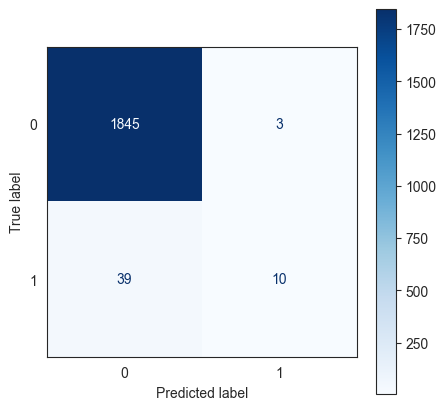

In [90]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, cmap=plt.cm.Blues)
plt.show()

### 5. Results and Evaluation

#### Random Forest Model: Confusion matric and classification report

In [ ]:
# Concfusion Matrix
# cm_rf_train = confusion_matrix(Y_train, Y_pred_rf_train)
# print("Random Forest Confusion Matrix for training data set: \n", cm_rf_train)

cm_rf = confusion_matrix(Y_test, Y_pred_rf)
print("Random Forest Confusion Matrix for test data set: \n")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels= [0,1])
disp.plot()
plt.show()

In [ ]:
# Classification Report
# cr_rf_train = classification_report(Y_train, Y_pred_rf_train)
# print("Random Forest Classification Report for training data set: \n", cr_rf_train)

cr_rf = classification_report(Y_test, Y_pred_rf)
print("Random Forest Classification Report for test data set: \n", cr_rf)

#### Logistic Regression Model: Confusion matric and classification report

In [ ]:
# Confusion Matrix
# cm_lr_train = confusion_matrix(Y_train, Y_pred_lr_train)
# print("Logistic Regression Confusion Matrix for training data set: \n", cm_lr_train)

cm_lr = confusion_matrix(Y_test, Y_pred_lr)
print("Logistic Regression Confusion Matrix for test data set: \n")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels= [0,1])
disp.plot()
plt.show()

In [ ]:
# Classification Report
# cr_lr_train = classification_report(Y_train, Y_pred_lr_train)
# print("Logistic Regression Classification Report for training data set: \n", cr_lr_train)

cr_lr = classification_report(Y_test, Y_pred_lr)
print("Logistic Regression Classification Report for test data set: \n", cr_lr)

#### Comparison: ROC Curve

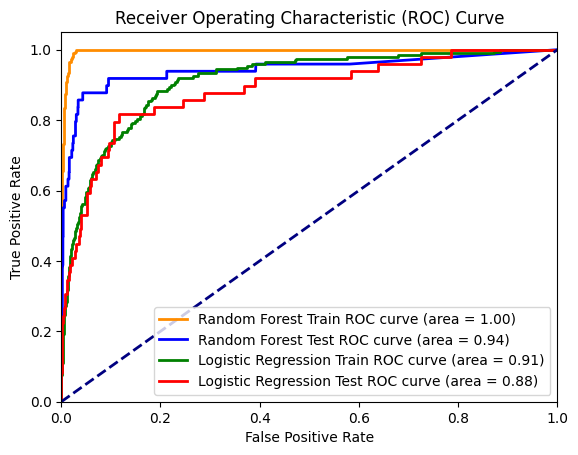

In [78]:
# Compute ROC curve and ROC area for Random Forest
fpr_rf_train, tpr_rf_train, _ = roc_curve(Y_train, rf.predict_proba(X_train)[:, 1])
roc_auc_rf_train = auc(fpr_rf_train, tpr_rf_train)

fpr_rf_test, tpr_rf_test, _ = roc_curve(Y_test, rf.predict_proba(X_test)[:, 1])
roc_auc_rf_test = auc(fpr_rf_test, tpr_rf_test)

# Compute ROC curve and ROC area for Logistic Regression
fpr_lr_train, tpr_lr_train, _ = roc_curve(Y_train, lr.predict_proba(X_train)[:, 1])
roc_auc_lr_train = auc(fpr_lr_train, tpr_lr_train)

fpr_lr_test, tpr_lr_test, _ = roc_curve(Y_test, lr.predict_proba(X_test)[:, 1])
roc_auc_lr_test = auc(fpr_lr_test, tpr_lr_test)

# Plot ROC curves
plt.figure()

# Plot ROC for Random Forest
plt.plot(fpr_rf_train, tpr_rf_train, color='darkorange', lw=2, label='Random Forest Train ROC curve (area = %0.2f)' % roc_auc_rf_train)
plt.plot(fpr_rf_test, tpr_rf_test, color='blue', lw=2, label='Random Forest Test ROC curve (area = %0.2f)' % roc_auc_rf_test)

# Plot ROC for Logistic Regression
plt.plot(fpr_lr_train, tpr_lr_train, color='green', lw=2, label='Logistic Regression Train ROC curve (area = %0.2f)' % roc_auc_lr_train)
plt.plot(fpr_lr_test, tpr_lr_test, color='red', lw=2, label='Logistic Regression Test ROC curve (area = %0.2f)' % roc_auc_lr_test)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [79]:
# Perform cross-validation
# cv_scores_rf = cross_val_score(rf, X, Y, cv=5, scoring='roc_auc')

# Print the cross-validation scores and the mean score
# print("Random Forest Cross-Validation Scores: ", cv_scores_rf)
# print("Mean Cross-Validation Score: ", cv_scores_rf.mean())